# **Lab 5 - Monte Carlo (MC) and Quasi-Monte Carlo (QMC) methods**

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Monte Carlo methods

### General idea


Monte Carlo methods are a class of stochastic approaches that leverage classical results in Probability and Statistics (mostly the Law of Large Numbers and the Central Limit Theorem) in order to estimate certain quantities. For instance, they can be used to estimate integrals in arbitrary dimension, offering a stochastic alternative to classical quadrature rules and related numerical methods.

In a nutshell, the idea arises by noticing that for any $f:\mathbb{R}^{d}\to\mathbb{R}$ and any probability measure $\mathbb{P}$ on $\mathbb{R}^{d}$, if $f\in L^{1}_{\mathbb{P}}(\mathbb{R}^{d})$, i.e. $\int_{\mathbb{R}^{d}}|f(\mathbf{x})|\mathbb{P}(d\mathbf{x})<+\infty$, then

$$\int_{\mathbb{R}^{d}}f(\mathbf{x})\mathbb{P}(d\mathbf{x})=\mathbb{E}\left[f(\mathbf{X})\right]\approx\frac{1}{N}\sum_{i=1}^{N}f(\mathbf{X}_i)$$

whenever $\mathbf{X}\sim\mathbb{P}$ is a $d$-dimensional random vector with probability distribution $\mathbb{P}$ and $\mathbf{X}_1,\dots\mathbf{X}_N\sim\mathbb{P}$ are i.i.d. replicas of $\mathbf{X}$.

Equivalently, if $\mathbb{P}$ admits a density $p:\mathbb{R}^{d}\to[0,+\infty)$,

$$\int_{\mathbb{R}^{d}}f(\mathbf{x})p(\mathbf{x})d\mathbf{x}=\mathbb{E}\left[f(\mathbf{X})\right]\approx\frac{1}{N}\sum_{i=1}^{N}f(\mathbf{X}_i)$$

Consequently, one can easily estimate the integral on the left-hand-side by using a simple aritmetic mean (up to knowing how to sample from $\mathbb{P}$!). Additionally, thanks to the Central Limit Theorem (CLT), if $N$ is sufficiently large, we can enrich our approximation by leveraging the following error bound

$$\left|\int_{\mathbb{R}^{d}}f(\mathbf{x})\mathbb{P}(d\mathbf{x})-\frac{1}{N}\sum_{i=1}^{N}f(\mathbf{X}_i)\right|\le z_{\alpha/2}\frac{\sigma}{\sqrt{N}}$$

which is known to hold with probability $1-\alpha$. Here,

- $z_{\beta}$ is the $1-\beta$ quantile of a standard gaussian distribution, i.e. $\mathbb{P}(Z>z_{\beta})=\beta$ whenever $Z\sim\mathcal{N}(0,1)$;

- $\sigma^2=\text{Var}(f(\mathbf{X}))$ is related to the variance at output.

<mark>**Exercise 1**</mark></br>

Consider the following integral in dimension $d=1$,

$$I = \int_{-\infty}^{+\infty}x^2e^{x-\frac{1}{2}x^2}dx,$$

whose exact value is known to be $I=\sqrt{8\pi e}$.

**Ex. 1.1**
Re-write the integral in the form $I=\int_{\mathbb{R}}f(x)p(x)dx$ where $p$ is the density function of a standard normal distribution.

In [2]:
p = lambda x: np.exp((-x**2)/2)/np.sqrt(2*np.pi)
f = lambda x: np.sqrt(2*np.pi)*(x**2)*np.exp(x)

**Ex. 1.2** Leveraging the representation at point (1), approximate $I$ using a Monte Carlo average with $N=10^4$ samples drawn from a standard normal distribution, $X\sim\mathcal{N}(0,1)$.

In [ ]:
I = (8*np.pi*np.e)**0.5 # Exact value

# MC sampling
def mc_sampling(N, f):
    samples = f(np.random.standard_normal(N))
    estimate = np.mean(samples)

    return estimate, samples

In [ ]:
mc_sampling(N = 10**4, f = f)[0] - I

np.float64(0.22147853991178224)

**Ex. 1.3** Enrich the estimate at point (2) by computing a confidence interval of level $1-\alpha=95\%$. Verify (empirically) that the confidence interval has desired level of confidence by repeating the calculation multiple times.

In [ ]:
# Enriching the pointwise estimate with a confidence interval
from scipy.stats import norm
alpha = 0.05
z = norm.ppf(1.0-alpha/2.0)

def confidence_bound(z, N_mean, N_var, sample_var = None):
    if sample_var == None:
        samples = f(np.random.standard_normal(N_var))
        sample_var = np.var(samples, ddof = 1)
    return z * np.sqrt(sample_var) / np.sqrt(N_mean)
    
# Hint: use np.var with optional argument ddof=1 to calculate sample variance
# ddof stands for "delta degrees of freedom"

In [ ]:
np.abs(mc_sampling(N = 10**4, f=f)[0] - I) <= confidence_bound(z, 10**4, 1000)

np.True_

In [ ]:
# Checking if the confidence is effective
# Idea: repeat the estimate 1000 times. How often does the CI contain the true value?

def ci_test(N_mean, f, z, N_var, N_test):
    alpha = 0
    for _ in range(N_test):
        alpha += int(np.abs(mc_sampling(N = N_mean, f=f)[0] - I) <= confidence_bound(z, N_mean, N_var))

    return alpha/N_test

In [76]:
ci_test(10**4, f, z, 10000, 1000)

0.941

**Ex. 1.4** Let $I_N$ denote the Monte Carlo estimate of $I$ when using $N$ samples. For every $N=2^5,2^6,\dots,2^{20}$ compute the relative error $|I-I_N|/I$ and plot it as a function of $N$. What trend do you observe?

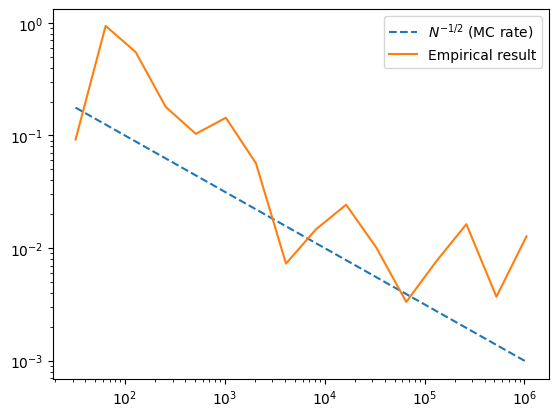

In [ ]:
Ns = 2**np.arange(5, 21) # Array of values of N = 2^5, 2^6, ..., 2^20
plt.loglog(Ns, 1.0/Ns**0.5, '--', label = '$N^{-1/2}$ (MC rate)') # Theoretical Monte Carlo rate

y = np.array([(np.abs(mc_sampling(N, f)[0] - I))/I for N in Ns])

plt.loglog(Ns, y, label = "Empirical result")
plt.legend()
plt.show()

**Ex. 1.5** Let $\varepsilon>0$. Leveraging the formula for the confidence interval, propose an adaptive algorithm for determining the number of samples $N_*$ for which one expects $|I-I_{N_*}|/I\le\varepsilon$ to hold with probability $1-\alpha$. Test your approach with $\varepsilon=0.01$.

In [83]:
N = 0
Nstar = 30
eps = 0.01

while(N < Nstar):
    N = Nstar
    Y = f(np.random.rand(N))
    mu = Y.mean()
    sigma = Y.var(ddof = 1)**0.5

    Nstar = int((z*sigma/(eps*mu))**2)
    print("Just used %d samples, suggested sample size is actually this: %d." % (N, Nstar))

Just used 30 samples, suggested sample size is actually this: 39721.
Just used 39721 samples, suggested sample size is actually this: 43209.
Just used 43209 samples, suggested sample size is actually this: 43042.


**Ex. 1.6** The code below contains a few lines of code where the integral $I$ is estimated using a Gaussian quadrature formula with weight $e^{-x^2/2}$ (Gauss-Hermite). Compare the performance of the MC estimate with that of the quadrature formula using $m=3,4,5,6$ collocation points.

In [85]:
from numpy.polynomial.hermite_e import hermegauss
m = 5
xknots, omegas = hermegauss(m)

g = lambda x: x**2*np.exp(x)
Ig = sum(g(xknots)*omegas)

print("True value:\t\t%.4f" % I)
print("Gauss-Hermite approx:\t%.4f\n" % Ig)
print("Relative error:\t\t%.4f" % (abs(I-Ig)/I))

True value:		8.2655
Gauss-Hermite approx:	8.2550

Relative error:		0.0013


**Ex. 1.7** Let's say that we now want to consider the following integral instead,
$$I={\large\int_{\mathbb{R}^d}}\left(\sum_{i=1}^{d}x_i^4e^{2x_i}\right)^{1/2}e^{-\frac{1}{2}\sum_{i=1}^{d}x_i^2}dx_1\dots dx_d.$$
where the dimension $d$ is arbitrary. Do you expect the results obtained at point (5) to change? Why? And, if so, how?

### Estimating volumes and probabilities

Being able to estimate integrals and expected values, also means that we can approximate lots of other stuff, such as probabilities, areas and volumes.

#### Volume estimation

Given any $\Omega\subset{\mathbb{R}^{d}}$ we can estimate the volume of $\Omega$, denote as $|\Omega|$, by noting that

$$|\Omega|=|C|\cdot\mathbb{E}[\mathbf{1}_{\Omega}(\mathbf{X})]=|C|\cdot\mathbb{E}[Y]$$

whenever $\Omega\subseteq C$ and $\mathbf{X}\sim\mathcal{U}_{C}$. In particular, if one takes $C$ to be a suitable hypercube containing $\Omega$, then $\mathbf{X}$ is easily generated and estimating $|\Omega|$ becomes straightforward!

<mark>**Exercise 2**</mark></br>

Let $B_d$ denote the unit ball in $\mathbb{R}^{d}$,
$$B_d:=\{(x_1,\dots,x_d)\in\mathbb{R}^{d}\;:\;x_1^2+\dots+x_d^2\le 1\}.$$
Leveraging the fact that $B_d\subset[-1,1]^d$, estimate the volume of the unit ball for $d=3,\dots,10$ using, each time, a Monte Carlo sample of size $N=10^5$. Show your results in a plot, highlighting how $|B_d|$ changes with $d$. To ensure robustness, enrich your plot by including the 95% confidence bands.

In [ ]:
ds = np.arange(3, 11) # array of spatial dimensions d = 3,...,10
volume = np.zeros(len(ds))
uncertainty = np.zeros(len(ds))

N = 100000
alpha = 0.05
z = norm.ppf(1.0-alpha/2.0)

for i in range(len(ds)):
  # TODO...
  # TODO...
  # TODO...

plt.plot(ds, volume)
plt.fill_between(ds, volume-uncertainty, volume+uncertainty, alpha = 0.25)
plt.xlabel("Dimension $d$")
plt.ylabel("$d$-dimensional volume")
None

#### Probability estimation

As we mentioned, we can also estimate events probabilities. For instance, given a random variable $X$ and an event $A\subset\mathbb{R}$, we have

$$\mathbb{P}(X\in A)=\mathbb{E}[\mathbf{1}_A(X)]=\mathbb{E}[Y].$$

Equivalently, if $X$ has density $p$,

$$\mathbb{P}(X\in A)=\int_{\mathbb{R}}\mathbf{1}_{A}(x)p(x)dx=\mathbb{E}[Y],$$

that is: we are back to our original problem of integral estimation where $f(x):=\mathbf{1}_{A}(x)$.

<mark>**Exercise 3** (A simple physical model)</mark></br>

Consider the spring system represented in the figure below, consisting of four nominally identical springs with elastic constants $k_i$, $i = 1,\dots, 4$ and subject to unit concentrated forces $F_1 = F_2 = F_3 = 1.$
Let $x_1, x_2$ and $x_3$ be the horizontal displacements of the three nodes, as indicated in the picture. The equilibrium equations of the horizontal component of the force in the nodes are</br></br>

$$\begin{cases}
k_1x_1+k_2(x_1-x_2)=F_1\\
k_2(x_2-x_1)+k_3(x_2-x_3)=F_2\\
k_3(x_3-x_2)+k_4x_3=F_3
\end{cases}
\iff
\left[
  \begin{array}{ccc}
  k_1+k_2 & -k_2 & 0\\
  -k_2 & k_2+k_3 & -k_3\\
  0 & -k_3 & k_3+k_4
  \end{array}
\right]
\left[
  \begin{array}{c}
  x_1\\
  x_2\\
  x_3
  \end{array}
\right]=
\left[
  \begin{array}{c}
  F_1\\
  F_2\\
  F_3
  \end{array}
\right].
$$
</br>
Now suppose that the four springs are randomly extracted from a population of springs having elasticity constant distributed as a lognormal random variable with parameters $\mu = 1$ and $\sigma=0.5$, that is, $k=e^{X}$ with $X\sim\mathcal{N}(\mu,\sigma^2)$. We want to calculate the probability that $x_2>1.2$, which corresponds to calculating the four dimensional integral

$$\mathbb{P}\left(x_2>1.2\right)=\int_{\mathbb{R}^4}\mathbf{1}_{(1.2,+\infty)}(x_2(k_1,\dots,k_4))p(k_1,\dots,k_4)dk_1\dots dk_4,$$

where $p$ is the joint probability distribution of the elasticity constants $k_1, k_2, k_3, k_4$.

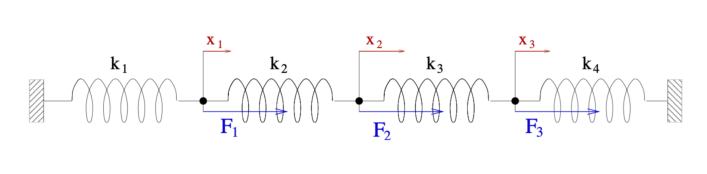

In [ ]:
import matplotlib.image as mpimg
try:
  picture = mpimg.imread('figure.png')
except:
  import gdown
  gdown.download(id = "1qowms4UJMnVSIZLcCFF1kfipzREZX1uI", output = "figure.png", quiet = True)
  picture = mpimg.imread('figure.png')

plt.figure(figsize = (12, 2))
plt.imshow(picture)
plt.axis('off')
plt.show()

**Ex. 3.1** Sample 1000 times the random variable $x_2 = x_2(k_1, k_2, k_3, k_4)$. Inspect the sample through an histogram.

In [ ]:
F1, F2, F3 = 1, 1, 1

km = 1   # mean of log(k_i)
ks = 0.5 # standard deviation of log(k_i)

N = 1000
X2 = np.zeros(N)

for i in range(N):
    #TODO ...
    #TODO ...
    #TODO ...

**Ex. 3.2** Estimate, on the basis of the previous sampling, the number of Monte Carlo samples required to estimate the probability $\mathbb{P}\left(x_2>1.2\right)$ with a relative error smaller than $5\%$ with a confidence level of $95\%$. Then, proceed with the estimation.


In [ ]:
#TODO ...
#TODO ...
#TODO ...

In [ ]:
#TODO ...
#TODO ...
#TODO ...

**Ex. 3.3** Repeat the previous point by changing the event to $\{x_2 > 1.5\}$. What conclusions can be drawn about the estimation of probabilities of rare events via Monte Carlo?

In [ ]:
#TODO ...
#TODO ...
#TODO ...

## Quasi-Monte Carlo methods

Quasi-Monte Carlo (QMC) methods are an alternative to classical Monte Carlo that aim at improving the convergence rate with respect to $N$. In particular, methods of this kind can provide a convergence of order close to $O\left(1/N\right)$ as opposed to $O(N^{-1/2})$. Specifically, some of these approaches achieve a convergence rate of $O\left(\log(N)^d/N\right)$ when estimating $d$-dimensional integrals.


In a nutshell, the idea behind QMC is still to rely on a "Monte Carlo like" approximation

$$\int_{[0,1]^{d}}f(x)dx\approx \frac{1}{N}\sum_{i=1}^{N}f(x_i)$$

but the points $x_1,\dots,x_N$ are chosen in a special (often deterministic) way. Specifically, they are chosen in order to cover the integration domain $[0,1]^d$ "as much as possible". Sequences of this kind are known as *low-discrepancy sequences* (see [The Koksma-Hlawka inequality](https://en.wikipedia.org/wiki/Low-discrepancy_sequence#The_Koksma.E2.80.93Hlawka_inequality)). Examples include **Sobol** and **Halton sequences**. The code below shows how these (deterministic) sampling strategies compare to classical uniform sampling in 2D. Everything is implemented in the submodule $\textsf{stats.qmc}$ of $\textsf{scipy}$.

In [ ]:
N = 128 # choosing powers of 2 is best for some QMC approaches such as Sobol sequencing
plt.figure(figsize = (9, 3))

# Uniform sampling
x = np.random.rand(N, 2)

plt.subplot(1,3,1)
plt.plot([0,1,1,0,0], [0,0,1,1,0], '--')
plt.plot(x[:,0], x[:, 1], '.')
plt.axis("square")
plt.axis("off")
plt.title("Uniform (random)")

# Sobol
from scipy.stats.qmc import Sobol
sobol = Sobol(d=2, scramble=False) # sequence generator
x = sobol.random(N)

plt.subplot(1,3,2)
plt.plot([0,1,1,0,0], [0,0,1,1,0], '--')
plt.plot(x[:,0], x[:, 1], '.')
plt.axis("square")
plt.axis("off")
plt.title("Sobol")

# Halton
from scipy.stats.qmc import Halton
halton = Halton(d=2, scramble=False) # sequence generator
x = halton.random(N)

plt.subplot(1,3,3)
plt.plot([0,1,1,0,0], [0,0,1,1,0], '--')
plt.plot(x[:,0], x[:, 1], '.')
plt.axis("square")
plt.axis("off")
plt.title("Halton")
None

NB: QMC methods typically rely on a **deterministic** sampling of the unit hypercube $[0,1]^d$. While potentially useful, the absence of randomness makes it harder to produce error estimates. For this reason, **these methods can be randomized** on purpose. A classical strategy for doing so is to rely on random shifting, i.e. on the transformation
$$\tilde{x}_i=(x_i+U)\;\text{mod}\;1$$

where $U\sim\mathcal{U}([0,1]^d)$. Then, one can recover the advantages of random methods, such as the use of confidence intervals to estimate the approximation accuracy. For Sobol and Halton sequences, in $\textsf{scipy}$, this is achieved by setting the optional argument "$\textsf{scramble}$" to True.

<mark>**Exercise 4**</mark></br>

Consider the following 5-dimensional integral in the variables $x,y,z,w,v$,

$$I=\int_{[-1,1]^5}\frac{x^3y^2e^{wv}}{1+z^4}dx\dots dv.$$

Clearly, $I=0$ (why??).

Pretending not to know this fact, estimate $I$ using $N=2^5,\dots,2^{20}$ collocation points. To this end, employ both MC and QMC (e.g., Sobol) and compare the results. In particular, plot the trend of $|I-I_N|$ for varying $N$. Do you observe the desired improvement in the convergence rate?

In [ ]:
d = 5
f = lambda x, y, z, w, v: x**3*y**2*np.exp(w*v)/(1.0+z**4)
Ns = 2**np.arange(5, 21)

#TODO ...
#TODO ...
#TODO ...

In [ ]:
#TODO ...
#TODO ...
#TODO ...